In [1]:
#%% Setup.

# Activate environment.
# ! . ~/env/bin/activate

# Requirements.

#! pip install --upgrade numpy torch scipy sklearn nibabel nilearn matplotlib

In [2]:
#%% Imports.
import numpy as np
import ardent

import matplotlib
%matplotlib inline
#%matplotlib notebook

# TODO: remove with ardent.io.
from pathlib import Path
import nibabel as nib 

/home/dtward/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#%% Load template and target.

#directory_path = Path('/home/dcrowley/image_lddmm_tensorflow')
directory_path = Path('/home/dtward/Documents/cis/ardent-work/neuronex2/datasets')
atlas_image_filename = 'average_template_50.img'
target_image_filename = '180517_Downsample.img'

atlasPath = directory_path / atlas_image_filename
targetPath = directory_path / target_image_filename

atlas = np.array(nib.load(str(atlasPath)).get_data()).astype(float).squeeze()
target = np.array(nib.load(str(targetPath)).get_data()).astype(float).squeeze()

In [4]:
#%% Downsample
def down2(I):
    nxd = np.array(I.shape)//2
    Id = np.zeros(nxd)
    down = [2,2,2]
    for i in range(down[0]):
        for j in range(down[1]):
            for k in range(down[2]):
                Id += I[i:down[0]*nxd[0]:down[0],
                        j:down[1]*nxd[1]:down[1],k:down[2]*nxd[2]:down[2]]/(down[0]*down[1]*down[2])
    return Id
atlas=down2(atlas)
target=down2(target)

In [5]:
#%% Reform and normalize images.

# Normalize.
# Compute mean absolute deviation.
atlas_mean_absolute_deviation = np.mean(np.abs(atlas - np.median(atlas)))
target_mean_absolute_deviation = np.mean(np.abs(target - np.median(target)))

## Pad with zeros.
atlas = np.pad(atlas, pad_width=1, mode='constant', constant_values=0)
#target = np.pad(target, pad_width=1, mode='constant', constant_values=0)


# Subtract mean.
atlas -= np.mean(atlas)
target -= np.mean(target)
# Divide by mean absolute deviation.
atlas /= atlas_mean_absolute_deviation
target /= target_mean_absolute_deviation



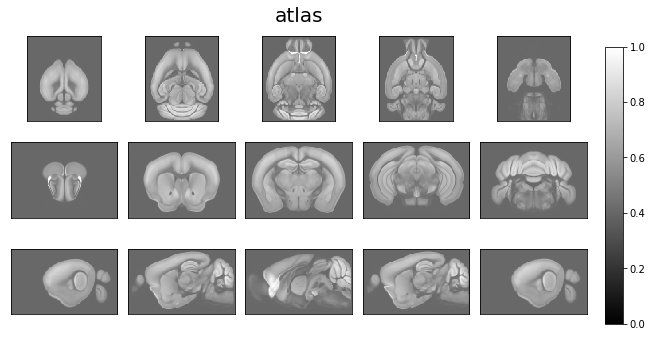

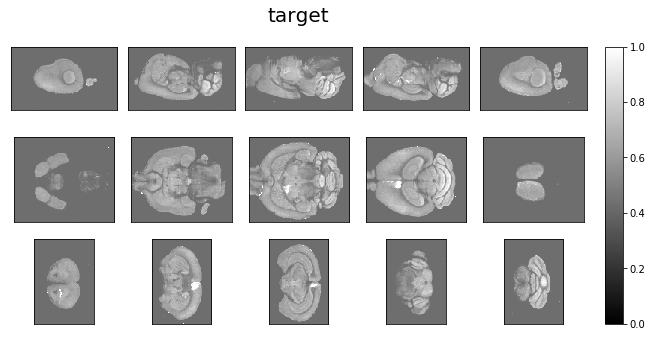

In [6]:
#%% Visualize images before registration.
# It is important to check that the images are oriented to one another 
# and do not require rotating or flipping.

ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(target, title='target', limit_mode='stdev')

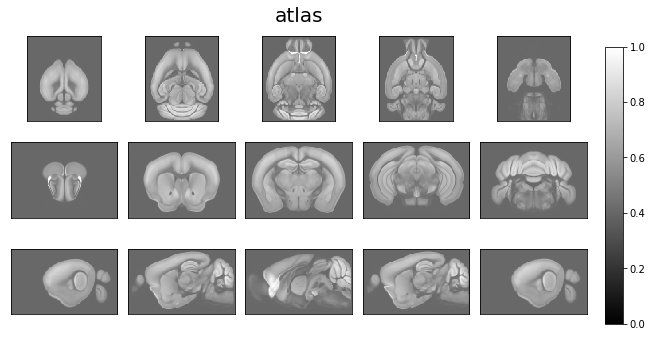

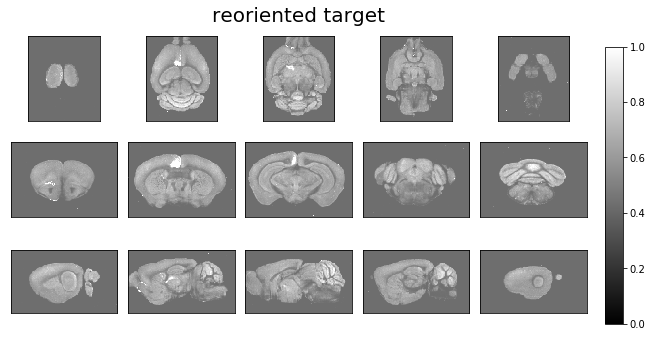

In [7]:
#%% Orient images.
# From looking at the two images we can see that they are not oriented.
# This must be corrected for prior to performing the registration.

# Here we will orient the target to the template (atlas).
reoriented_target = np.copy(target)
reoriented_target = np.rot90(reoriented_target, axes=(1,2))
reoriented_target = np.rot90(reoriented_target, axes=(2,0))
# np.moveaxis does nothing when destination == source.
# reoriented_target = np.moveaxis(reoriented_target, source=[0,1,2], destination=[0,1,2])
reoriented_target = np.flip(reoriented_target, axis=0)
reoriented_target = np.flip(reoriented_target, axis=1)

# If we performed an odd number of inversions with the above line, 
# we must perform a flip to correct for inverting the image. 
# The simplest flip is a sagittal flip, since that is the axis of innate symmetry in the brain.
# In this case, we can see from the atlas visualization that this is axis 2 (the last row).
# The above line performed 2 inversions, so the following line is commented out.
# reoriented_target = np.flip(reoriented_target, axis=2)

# Verify proper orientation.
ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(reoriented_target, title='reoriented target', limit_mode='stdev')

In [8]:
#%% Use reoriented target.
# Once we've finished orienting target, we use the result as target.
# A copy is taken to get a real array rather than a view.
target = reoriented_target.copy()

## Pad images to same shape.
#atlas, target = ardent.lddmm.torch_lddmm_wrapper._pad_to_same_shape(atlas, target)

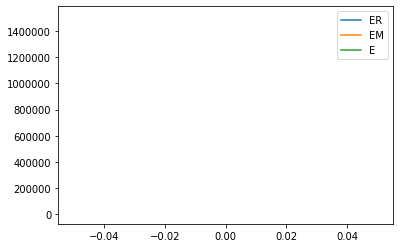

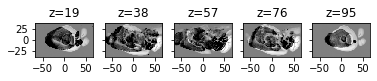

Completed iteration 0, E=1515616.185645548, EM=1515616.185645548, ER=0.0
Completed iteration 1, E=1439746.3896011012, EM=1439746.3601291543, ER=0.029471946925305803
Completed iteration 2, E=1374332.8181724823, EM=1374332.7088585808, ER=0.1093139015174417
Completed iteration 3, E=1318757.0640977623, EM=1318756.834408389, ER=0.22968937335595885
Completed iteration 4, E=1271751.9560957213, EM=1271751.5735251815, ER=0.38257053990478274


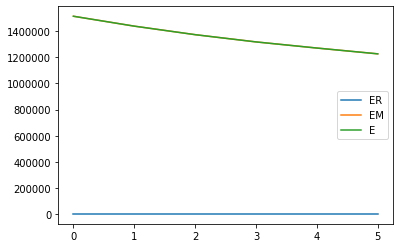

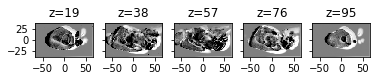

Completed iteration 5, E=1227309.6388530184, EM=1227309.076616719, ER=0.5622362995789485
Completed iteration 6, E=1187049.2233205668, EM=1187048.4603275205, ER=0.7629930462313085
Completed iteration 7, E=1149542.3804708144, EM=1149541.4014316695, ER=0.9790391448511431
Completed iteration 8, E=1115334.691158344, EM=1115333.4852330505, ER=1.2059252935612872
Completed iteration 9, E=1083324.4407943923, EM=1083323.0002246904, ER=1.4405697018321264


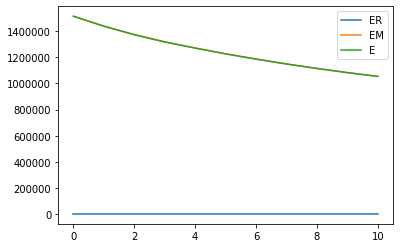

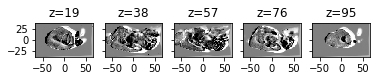

Completed iteration 10, E=1054312.7786014518, EM=1054311.099957548, ER=1.6786439036852672
Completed iteration 11, E=1028107.6813565345, EM=1028105.7656858747, ER=1.9156706597597544
Completed iteration 12, E=1005683.678247044, EM=1005681.5293162775, ER=2.148930766560758
Completed iteration 13, E=987012.8958629933, EM=987010.5199563417, ER=2.3759066515872242
Completed iteration 14, E=970711.3029335049, EM=970708.70417003, ER=2.598763474968819


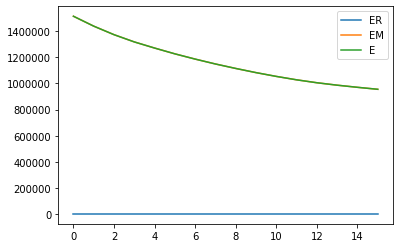

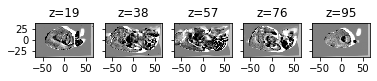

Completed iteration 15, E=955485.74190731, EM=955482.9231136035, ER=2.8187937064808595
Completed iteration 16, E=941293.7300162857, EM=941290.6940857016, ER=3.0359305841141486
Completed iteration 17, E=928700.1515842256, EM=928696.9030766655, ER=3.248507560102617
Completed iteration 18, E=917031.6813503895, EM=917028.2242444225, ER=3.4571059670199995
Completed iteration 19, E=906645.1595399004, EM=906641.4991969834, ER=3.6603429169091055


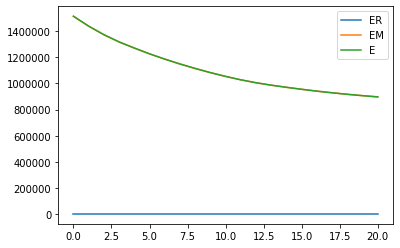

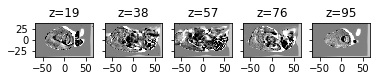

Completed iteration 20, E=897187.15079595, EM=897183.2917127514, ER=3.8590831985520935
Completed iteration 21, E=888465.6756168131, EM=888461.621626733, ER=4.053990080125484
Completed iteration 22, E=880526.7786481364, EM=880522.5336833341, ER=4.244964802247118
Completed iteration 23, E=873285.4435022327, EM=873281.0112021783, ER=4.432300054321574
Completed iteration 24, E=866625.5258373822, EM=866620.90932197, ER=4.6165154122842536


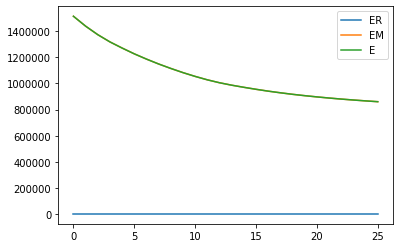

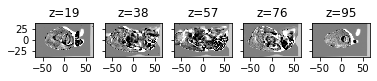

Completed iteration 25, E=860438.7384020764, EM=860433.9402054772, ER=4.798196599219417
Completed iteration 26, E=854589.9537680518, EM=854584.9760248549, ER=4.977743196843157
Completed iteration 27, E=849035.8806065146, EM=849030.7253850745, ER=5.155221440126831
Completed iteration 28, E=843750.9935101174, EM=843745.6628496152, ER=5.33066050223763
Completed iteration 29, E=838742.8224384594, EM=838737.3182053086, ER=5.504233150740286


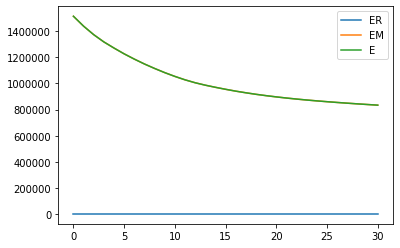

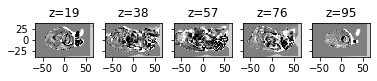

Completed iteration 30, E=833948.6707892375, EM=833942.9946465332, ER=5.676142704369621
Completed iteration 31, E=829299.2655218145, EM=829293.4189467502, ER=5.846575064224468
Completed iteration 32, E=824801.0906136071, EM=824795.0748716493, ER=6.015741957841826
Completed iteration 33, E=820451.6081925699, EM=820445.424367375, ER=6.183825194988707
Completed iteration 34, E=816255.208583174, EM=816248.8574812827, ER=6.3511018914175255


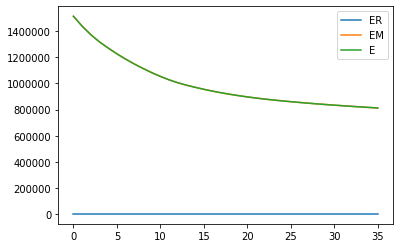

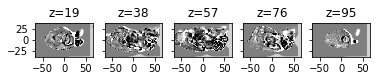

Completed iteration 35, E=812186.0901426392, EM=812179.5724193781, ER=6.517723261162045
Completed iteration 36, E=808273.6579490463, EM=808266.9739666654, ER=6.683982380905991
Completed iteration 37, E=804485.9875727333, EM=804479.1376250794, ER=6.849947653971713
Completed iteration 38, E=800882.3295938167, EM=800875.3139303301, ER=7.01566348659857
Completed iteration 39, E=797439.3414074023, EM=797432.1605075973, ER=7.180899805017688


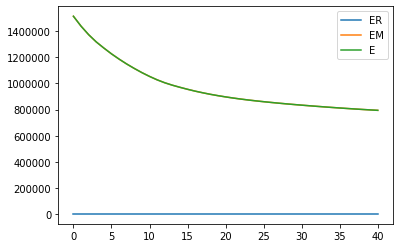

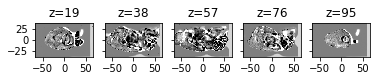

Completed iteration 40, E=794176.2029221436, EM=794168.857311948, ER=7.345610195693587
Completed iteration 41, E=791016.403059797, EM=791008.893428994, ER=7.509630802989642
Completed iteration 42, E=787979.644647114, EM=787971.971700056, ER=7.672947058012761
Completed iteration 43, E=785026.4990438353, EM=785018.6635426711, ER=7.835501164170137
Completed iteration 44, E=782163.9732425979, EM=782155.9757945524, ER=7.997448045494496


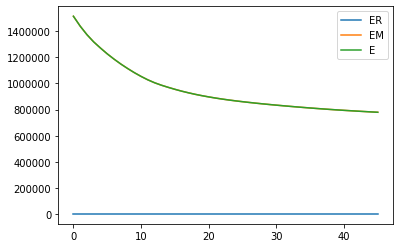

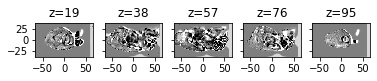

Completed iteration 45, E=779381.5827487041, EM=779373.4240014022, ER=8.158747301872157
Completed iteration 46, E=776742.9638147033, EM=776734.6441470522, ER=8.319667651139401
Completed iteration 47, E=774234.5625397809, EM=774226.0826593789, ER=8.479880402026625
Completed iteration 48, E=771892.5599310207, EM=771883.920585869, ER=8.639345151750716
Completed iteration 49, E=769645.7655322511, EM=769636.9678928965, ER=8.797639354599877


In [9]:
#%% Perform registration.

# Instantiate Transform object.
transform = ardent.Transform()
transform.register(template=atlas, target=target, 
                   sigmaR=1e3, sigmaA=None, 
                   eV=1e0, eT=1e-5, eL=1e-8, 
                   niter=50, draw=True)

In [10]:
#%% Apply the transformation.
# The transformation is the result of the registration, and it can be applied to arbitrary images, 
# although presently they should be preprocessed as the atlas and target were.
# Here we will simply apply the transformation to both the atlas and target, 
# making them match up with each other.
# i.e. deformed_target should resemble atlas, and deformed_atlas should resemble target.

deformed_atlas = transform.apply_transform(subject=atlas, deform_to='target', save_path=None)
deformed_target = transform.apply_transform(subject=target, deform_to='template', save_path=None)

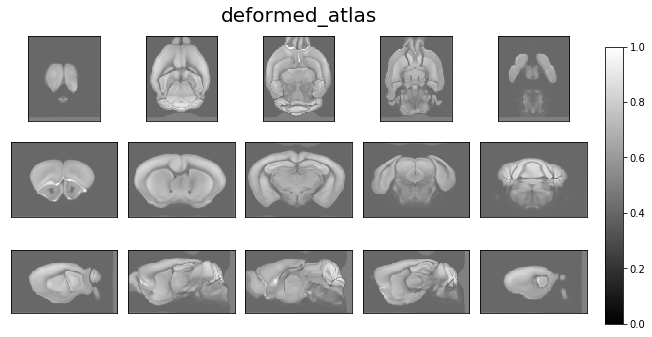

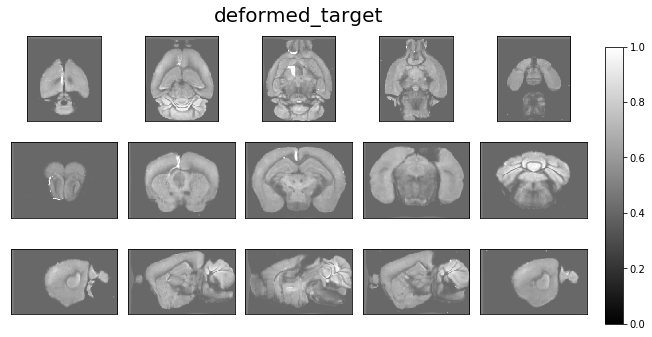

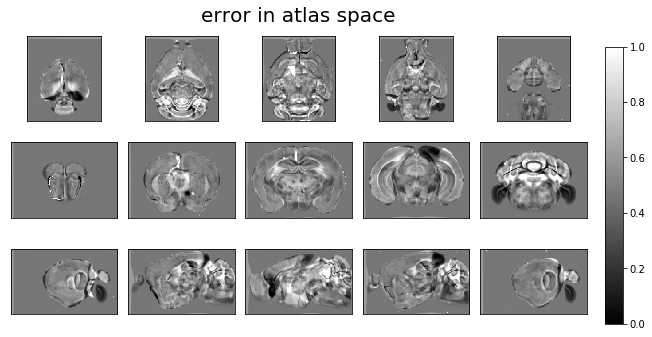

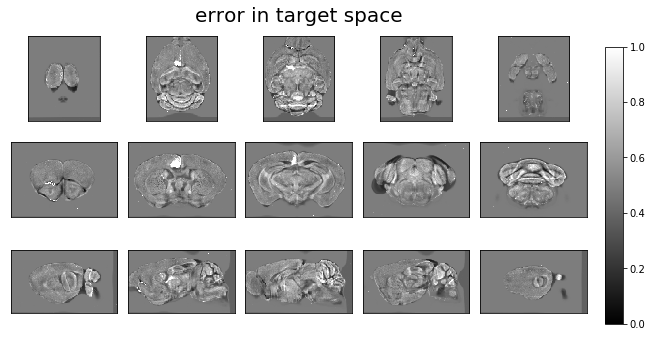

In [11]:
#%% Visualize results.

ardent.heatslices(deformed_atlas, title='deformed_atlas', limit_mode='stdev')
ardent.heatslices(deformed_target, title='deformed_target', limit_mode='stdev')

# To simply visualize error we plot the difference between images.
ardent.heatslices(deformed_target - atlas, title='error in atlas space', limit_mode='stdev')
ardent.heatslices(target - deformed_atlas, title='error in target space', limit_mode='stdev')
#ardent.heatslices(target - atlas, title='error before registration', limit_mode='stdev') # this needs to be changed